In [1]:
# Prepare the jupyter-notebook environment.
%config IPCompleter.greedy=True
%matplotlib inline

In [ ]:
# Import the useful modules of several libraries.
from tsa.array import * 
from tsa.normalization import * 
from tsa.matrix import *
from tsa.features import *
from tsa.dimensionality import *
from tsa.distances import *


import folium
import matplotlib.pyplot as plt

import pandas as pd 
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
from IPython.display import display
 
from sklearn.utils import shuffle
from sklearn.preprocessing import scale
from sklearn.feature_selection import VarianceThreshold

from sklearn.model_selection import GridSearchCV
from sklearn import svm

In [3]:
# Load the metadata.
all_sites = pd.read_csv("./data-enerNoc/all-data/meta/all_sites.csv")

In [4]:
# Show all the metadata.
print(all_sites)

    SITE_ID              INDUSTRY                   SUB_INDUSTRY    SQ_FT  \
0         6   Commercial Property  Shopping Center/Shopping Mall   161532   
1         8   Commercial Property  Shopping Center/Shopping Mall   823966   
2         9   Commercial Property               Corporate Office   169420   
3        10   Commercial Property  Shopping Center/Shopping Mall  1029798   
4        12   Commercial Property              Business Services   179665   
5        13   Commercial Property         Commercial Real Estate   185847   
6        14   Commercial Property              Business Services  1675720   
7        21   Commercial Property  Shopping Center/Shopping Mall   783982   
8        22   Commercial Property        Bank/Financial Services   318130   
9        25   Commercial Property  Shopping Center/Shopping Mall  1807149   
10       29   Commercial Property  Shopping Center/Shopping Mall   377537   
11       30   Commercial Property        Bank/Financial Services   496517   

In [5]:
# Plots the ubication of each local.
colors = {'Commercial Property' : 'red', 'Education' : 'blue', 'Food Sales & Storage': 'green', 'Light Industrial' : 'orange'}
all_sites["SITE_ID"].apply(str)
map_osm = folium.Map(location=[37.56641953,-79.56338786], zoom_start=3.4)

all_sites.apply(lambda row:folium.CircleMarker(location=[row["LAT"], row["LNG"]], 
                                               radius=10, 
                                               fill=True,
                                               fill_opacity=1,
                                               popup=str(row['SITE_ID']),
                                               fill_color=colors[row['INDUSTRY']]
                                              )
                                             .add_to(map_osm), axis=1)
map_osm


In [7]:
# Define the number of points per hour, day, week and month.
points_per_hour = 60 / 5
points_per_day = 24 * points_per_hour
points_per_week = 7 * points_per_day
points_per_month = 4 * points_per_week

file_names = []
numpy_values = []
numpy_dates = []
l = 0
# Load the local ids, the consumption values and the dates for each local.
for name in all_sites["SITE_ID"].values:
    file_names.append(name)
    df = pd.read_csv('./data-enerNoc/all-data/csv/' + str(name) + ".csv")
    numpy_values.append(df['value'].as_matrix())
    l = l + len(df['value'].as_matrix())
    numpy_dates.append(df['dttm_utc'].as_matrix())
print(" Total Length: " + str(l))

 Total Length: 10531288


In [8]:
# re-dimensions the array and saves the data in a binary file.
"""
for i in range(len(numpy_values)):
    #two points per hour
    numpy_values[i] = visvalingam(array([range(len(numpy_values[i])), numpy_values[i].tolist()]), int(100000/6)).to_numpy()[1]
    print(i)
arr_created_once = np.stack(numpy_values, axis=0)
"""

'\nfor i in range(len(numpy_values)):\n    #two points per hour\n    numpy_values[i] = visvalingam(array([range(len(numpy_values[i])), numpy_values[i].tolist()]), int(100000/6)).to_numpy()[1]\n    print(i)\narr_created_once = np.stack(numpy_values, axis=0)\n'

In [9]:
#np.save("./time-series-redimension-applied", arr_created_once)

# Load the numpy arrays from the binary file and creates a TSA array.
arr_tmp  = array(np.load("./time-series-redimension-applied.npy"))


In [11]:
import time
start = time.time()
# Calculates several features of each time series in order to create the features matrix. 
features = np.stack([abs_energy(arr_tmp).to_numpy(),
                    absolute_sum_of_changes(arr_tmp).to_numpy(),
                    count_above_mean(arr_tmp).to_numpy(),
                    count_below_mean(arr_tmp).to_numpy(),
                    first_location_of_maximum(arr_tmp).to_numpy(),
                    first_location_of_minimum(arr_tmp).to_numpy(),
                    has_duplicates(arr_tmp).to_numpy(),
                    has_duplicate_max(arr_tmp).to_numpy(),
                    kurtosis(arr_tmp).to_numpy(),
                    last_location_of_maximum(arr_tmp).to_numpy(),
                    last_location_of_minimum(arr_tmp).to_numpy(),
                    has_duplicate_min(arr_tmp).to_numpy(),
                    longest_strike_above_mean(arr_tmp).to_numpy(),
                    longest_strike_below_mean(arr_tmp).to_numpy(),
                    maximum(arr_tmp).to_numpy(),
                    mean_absolute_change(arr_tmp).to_numpy(),
                    minimum(arr_tmp).to_numpy(),
                    number_crossing_m(arr_tmp, 0).to_numpy(),
                    mean(arr_tmp).to_numpy(),
                    median(arr_tmp).to_numpy(),
                    mean_change(arr_tmp).to_numpy(),
                    ratio_value_number_to_time_series_length(arr_tmp).to_numpy(),
                    skewness(arr_tmp).to_numpy(),
                    standard_deviation(arr_tmp).to_numpy(),
                    sum_of_reoccurring_values(arr_tmp).to_numpy(),
                    sum_values(arr_tmp).to_numpy(),
                    variance(arr_tmp).to_numpy(),
                    variance_larger_than_standard_deviation(arr_tmp).to_numpy()
                            ])
print("Time to extract the features : " + str(time.time() - start) )
features = features.transpose()

Time to extract the features : 12.840500831604004


In [12]:
# Defines the Features matrix and the Targets matrix
y = all_sites["SUB_INDUSTRY"].values
X = features

In [13]:
#Preprocess the X matrix using An Scale method.
X = scale(X)
print(X)

[[-0.33260699 -0.17364087  0.44343333 ... -0.25878153 -0.44142746
   0.14285714]
 [ 0.19432987  1.1430834   0.44119117 ...  0.61362536  2.36378292
   0.14285714]
 [-0.33893209 -0.34476263 -0.58796341 ... -0.29861783 -0.42157752
   0.14285714]
 ...
 [-0.37651848 -0.54247401 -1.36263205 ... -0.58618653 -0.51190807
   0.14285714]
 [ 0.04050261  0.89753152  0.31002441 ...  0.41959114  1.65371764
   0.14285714]
 [ 0.02313514  0.55116075 -0.44502527 ...  0.47541541  0.88426308
   0.14285714]]


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [14]:
# Makes several shuffles to distribute the samples.
for i in range(15):
    X, y, file_names = shuffle(X, y, file_names, random_state=0)

In [15]:
# Creates a model, fits it and predicts a subset of samples.
files_test = []
list_test_indices = []
for i in range(len(file_names)):
    if file_names[i] in [92, 45, 761, 10, 766, 400, 673, 49, 144, 496, 731, 281, 213, 197, 399]:
        list_test_indices.append(i)
        files_test.append(file_names[i])

        
X_train = np.delete(X, list_test_indices, 0)
X_test = np.take(X, list_test_indices, 0)
y_train = np.delete(y, list_test_indices)
y_test = np.take(y, list_test_indices)


k_range_parameter = {'degree':[3,4],'shrinking':[True,False],'probability':[True,False]}

# SVC is selected because of: >50 samples, predicting a category, labeled data and <100K samples. Good results.
clf = svm.SVC()

mygridsearch = GridSearchCV(clf, k_range_parameter, cv = 10, scoring = 'accuracy' )
mygridsearch.fit(X_train, y_train)

print("Cross-validation Score:" + str(mygridsearch.best_score_) + "%")
bestclassifier = mygridsearch.best_estimator_
y_pred = bestclassifier.predict(X_test)
print ("Test Score: " + str(sum(y_pred==y_test)/float(len(y_pred))) + "%")
print("Parameters used: "+ str(mygridsearch.best_params_))



/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Cross-validation Score:0.6%
Test Score: 0.8%
Parameters used: {'degree': 3, 'probability': True, 'shrinking': True}


In [16]:
print("MY TEST VECTOR: " + str(y_test))
print("MY PREDICTION: " + str(y_pred))
print("NUMBER OF ERRORS: " + str(sum(y_pred != y_test)))
print("ERROR RATE: " + str(1 - sum(y_pred == y_test) / float(len(y_pred))) + "%")
print("ACCURACY: " + str(sum(y_pred == y_test) / float(len(y_pred))) + "%")


MY TEST VECTOR: ['Grocer/Market' 'Primary/Secondary School' 'Food Processing'
 'Food Processing' 'Grocer/Market' 'Primary/Secondary School'
 'Grocer/Market' 'Food Processing' 'Shopping Center/Shopping Mall'
 'Shopping Center/Shopping Mall' 'Manufacturing'
 'Primary/Secondary School' 'Shopping Center/Shopping Mall'
 'Primary/Secondary School' 'Grocer/Market']
MY PREDICTION: ['Grocer/Market' 'Primary/Secondary School' 'Food Processing'
 'Food Processing' 'Grocer/Market' 'Primary/Secondary School'
 'Grocer/Market' 'Food Processing' 'Shopping Center/Shopping Mall'
 'Shopping Center/Shopping Mall' 'Food Processing'
 'Primary/Secondary School' 'Primary/Secondary School' 'Food Processing'
 'Grocer/Market']
NUMBER OF ERRORS: 3
ERROR RATE: 0.19999999999999996%
ACCURACY: 0.8%


In [17]:
# Associate Industries and Subindustries.
subindustry_and_industries = {'Corporate Office': 'Commercial Property',
                              'Commercial Real Estate': 'Commercial Property',
                              'Shopping Center/Shopping Mall': 'Commercial Property',
                              'Food Processing': 'Light Industrial' ,
                              'Manufacturing': 'Light Industrial',
                              'Other Light Industrial': 'Light Industrial',
                              'Grocer/Market': 'Food Sales & Storage',
                              'Primary/Secondary School': 'Education',
                              'Business Services': 'Commercial Property',
                              'Bank/Financial Services' : 'Commercial Property'}

In [18]:
# Print the obtained results.
prediction_dataframe = df = pd.DataFrame(columns=['industry_test', 
                                                  'industry_pred',
                                                  'y_test',
                                                  'y_pred',
                                                  'file'])
for a, b, c in zip(y_test, y_pred, files_test): 
    prediction_dataframe = prediction_dataframe.append({"industry_test":subindustry_and_industries[a], "industry_pred": subindustry_and_industries[b], 'y_test': a, 'y_pred': b, "file":c}, ignore_index=True)
print(prediction_dataframe)

           industry_test         industry_pred                         y_test  \
0   Food Sales & Storage  Food Sales & Storage                  Grocer/Market   
1              Education             Education       Primary/Secondary School   
2       Light Industrial      Light Industrial                Food Processing   
3       Light Industrial      Light Industrial                Food Processing   
4   Food Sales & Storage  Food Sales & Storage                  Grocer/Market   
5              Education             Education       Primary/Secondary School   
6   Food Sales & Storage  Food Sales & Storage                  Grocer/Market   
7       Light Industrial      Light Industrial                Food Processing   
8    Commercial Property   Commercial Property  Shopping Center/Shopping Mall   
9    Commercial Property   Commercial Property  Shopping Center/Shopping Mall   
10      Light Industrial      Light Industrial                  Manufacturing   
11             Education    

In [19]:
# We have found the next errors:

# 92  pred: Food Processing.          Test: Primary/Secondary School.      Different Industries.
# 49  pred: Primary/Secondary School. Test: Shopping Center/Shopping Mall. Different Industry.
# 761 pred: Food Processing.          Test: Manufacturing.                 Same Indsutry.

# Let's study those three strange cases.


# Case I.
# 92  pred: Food Processing.          Test: Primary/Secondary School.      Different Industries.

# Prints the ubication of this local in comparison with the Food Processing locals.
colors = {'Commercial Property' : 'red', 'Education' : 'blue', 'Food Sales & Storage': 'green', 'Light Industrial' : 'orange'}
df_si = all_sites['SUB_INDUSTRY'] == "Food Processing"
df_id = all_sites['SITE_ID'] == 92
map_osm = folium.Map(location=[37.56641953,-79.56338786], zoom_start=3.4)

all_sites[ (df_id| df_si)].apply(lambda row:folium.CircleMarker(location=[row["LAT"], row["LNG"]], 
                                              radius=10, 
                                               fill=True,
                                               fill_opacity=1,
                                               popup=str(row['SITE_ID']),
                                            fill_color=colors[row['INDUSTRY']]
                                              )
                                             .add_to(map_osm), axis=1)
                                           
map_osm

In [20]:
# Let's make a quick comparison between the local of study and the Food Processing locals. Let's compare the first month.
df_fp = all_sites['SUB_INDUSTRY'] == "Food Processing"
food_processing_id = all_sites[df_fp]["SITE_ID"].values
list_of_values = []
values_92 = pd.read_csv('./data-enerNoc/all-data/csv/' + str(92) + ".csv")["value"].values
i = 0
for name in food_processing_id:
    df = pd.read_csv('./data-enerNoc/all-data/csv/' + str(name) + ".csv")
    list_of_values.append(df["value"].values.tolist())
    i = i +1
#let's explore quickly the first month
profile, index = stomp(array(values_92), array(np.stack([np.array(l[0:int(points_per_month)]) for l in list_of_values])), int(points_per_month))

In [21]:
# Let's calculate if there are locals with Food Processing behaviour similar to this local.
distances = profile.to_numpy()
min_distance = distances[0]
index_md = 0
for d in range(len(distances)):
    if(distances[d] < min_distance):
        min_distance = distances[d]
        index_md = d

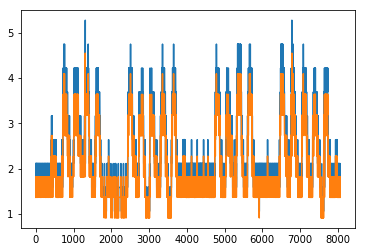

In [22]:
# Let's plot the time-series of each local.
plt.figure(1)
plt.plot(range(int(points_per_month)), values_92[0:int(points_per_month)])
plt.plot(range(int(points_per_month)), list_of_values[index_md][0:int(points_per_month)])
plt.show()

In [23]:
# Let's print the metadata of each local.
print(all_sites[(all_sites["SITE_ID"] == 92)])
print(all_sites[(all_sites["SITE_ID"]== food_processing_id[d])])

    SITE_ID   INDUSTRY              SUB_INDUSTRY   SQ_FT        LAT  \
26       92  Education  Primary/Secondary School  105530  40.243922   

          LNG         TIME_ZONE TZ_OFFSET  
26 -74.917719  America/New_York    -04:00  
    SITE_ID          INDUSTRY     SUB_INDUSTRY   SQ_FT       LAT        LNG  \
99      887  Light Industrial  Food Processing  381939  38.83195 -75.825022   

           TIME_ZONE TZ_OFFSET  
99  America/New_York    -04:00  


In [24]:
# There is a behaviour so similar of those locals so, maybe an inspector should reviiew those locals and get conclusions.
# Maybe another rate of payment should be suitable.

# Let's see the ubication of those locals.
colors = {'Commercial Property' : 'red', 'Education' : 'blue', 'Food Sales & Storage': 'green', 'Light Industrial' : 'orange'}
df_92 = all_sites['SITE_ID'] == 92
df_673 = all_sites['SITE_ID'] == 673
map_osm = folium.Map(location=[37.56641953,-79.56338786], zoom_start=3.4)

all_sites[(df_673 | df_92)].apply(lambda row:folium.CircleMarker(location=[row["LAT"], row["LNG"]], 
                                              radius=10, 
                                               fill=True,
                                               fill_opacity=1,
                                               popup=str(row['SITE_ID']),
                                            fill_color=colors[row['INDUSTRY']]
                                              )
                                             .add_to(map_osm), axis=1)
                                           
map_osm

In [25]:
# Case II.

# 49  pred: Primary/Secondary School. Test: Shopping Center/Shopping Mall. Different Industry.

# Let's compare the ubication of this local and the Primary/Secondary Schools.
colors = {'Commercial Property' : 'red', 'Education' : 'blue', 'Food Sales & Storage': 'green', 'Light Industrial' : 'orange'}
df_92_fp = all_sites['SUB_INDUSTRY'] == "Primary/Secondary School"
df_49_si = all_sites['SITE_ID'] == 49
map_osm = folium.Map(location=[37.56641953,-79.56338786], zoom_start=3.4)

all_sites[(df_49_si | df_92_fp)].apply(lambda row:folium.CircleMarker(location=[row["LAT"], row["LNG"]], 
                                              radius=10, 
                                               fill=True,
                                               fill_opacity=1,
                                               popup=str(row['SITE_ID']),
                                            fill_color=colors[row['INDUSTRY']]
                                              )
                                             .add_to(map_osm), axis=1)
                                           
map_osm

In [26]:
# Let's get the profile and index of this local and the Primary/Secondary School locals.
df_fp = all_sites['SUB_INDUSTRY'] == "Primary/Secondary School"
primary_secondary_school_id = all_sites[df_fp]["SITE_ID"].values
list_of_values = []
values_49 = pd.read_csv('./data-enerNoc/all-data/csv/' + str(49) + ".csv")["value"].values
i = 0
for name in primary_secondary_school_id:
    df = pd.read_csv('./data-enerNoc/all-data/csv/' + str(name) + ".csv")
    list_of_values.append(df["value"].values.tolist())
    i = i +1
profile, index = stomp(array(values_49), array(np.stack([np.array(l[0:int(points_per_month)]) for l in list_of_values])), int(points_per_month))

In [27]:
# Let's get the most similar Primary7Secondary School
distances = profile.to_numpy()
min_distance = distances[0]
index_md = 0
for d in range(len(distances)):
    if(distances[d] < min_distance):
        min_distance = distances[d]
        index_md = d

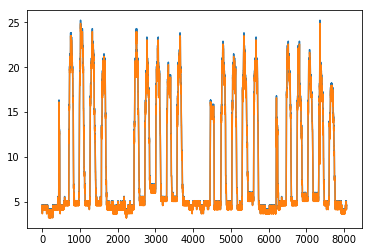

In [29]:
# Let's plot those two locals in the same graphic.
plt.figure(1)
plt.plot(range(int(points_per_month)), values_49[0:int(points_per_month)])
plt.plot(range(int(points_per_month)), list_of_values[index_md][0:int(points_per_month)])
plt.show()

In [30]:
# Let's print the metadata of each local.
print(all_sites[(all_sites["SITE_ID"] == 49)])
print(all_sites[(all_sites["SITE_ID"]== primary_secondary_school_id[d])])

    SITE_ID             INDUSTRY                   SUB_INDUSTRY   SQ_FT  \
19       49  Commercial Property  Shopping Center/Shopping Mall  497092   

          LAT        LNG         TIME_ZONE TZ_OFFSET  
19  41.216176 -78.148092  America/New_York    -04:00  
    SITE_ID   INDUSTRY              SUB_INDUSTRY   SQ_FT        LAT  \
49      275  Education  Primary/Secondary School  108405  40.269343   

          LNG         TIME_ZONE TZ_OFFSET  
49 -74.745143  America/New_York    -04:00  


In [31]:
# The locals seems to have exactly the same behaviour, 
# so an inspector should visit those locals and offer a solution, maybe another payment rate.
colors = {'Commercial Property' : 'red', 'Education' : 'blue', 'Food Sales & Storage': 'green', 'Light Industrial' : 'orange'}
df_49 = all_sites['SITE_ID'] == 49
df_270 = all_sites['SITE_ID'] == 270
map_osm = folium.Map(location=[37.56641953,-79.56338786], zoom_start=3.4)

all_sites[(df_49 | df_270)].apply(lambda row:folium.CircleMarker(location=[row["LAT"], row["LNG"]], 
                                              radius=10, 
                                               fill=True,
                                               fill_opacity=1,
                                               popup=str(row['SITE_ID']),
                                            fill_color=colors[row['INDUSTRY']]
                                              )
                                             .add_to(map_osm), axis=1)
                                           
map_osm

In [32]:
# Case III

# 761 pred: Food Processing.          Test: Manufacturing.                 Same Indsutry

# Let's plot the ubication of this locals agianst the location of Food Processing.

colors = {'Manufacturing' : 'red', 'Food Processing' : 'blue'}
df_mf = all_sites['SUB_INDUSTRY'] == "Food Processing"
df_761 = all_sites['SITE_ID'] == 761
map_osm = folium.Map(location=[37.56641953,-79.56338786], zoom_start=3.4)

all_sites[(df_761 | df_mf)].apply(lambda row:folium.CircleMarker(location=[row["LAT"], row["LNG"]], 
                                              radius=10, 
                                               fill=True,
                                               fill_opacity=1,
                                               popup=str(row['SITE_ID']),
                                            fill_color=colors[row['SUB_INDUSTRY']]
                                              )
                                             .add_to(map_osm), axis=1)
                                           
map_osm

In [33]:
# Let's compare the behaviour of the Manufacturing locals and the Food processing locals.
df_fp = all_sites['SUB_INDUSTRY'] == "Food Processing"
food_processing_id = all_sites[df_fp]["SITE_ID"].values
list_of_values = []
values_761 = pd.read_csv('./data-enerNoc/all-data/csv/' + str(761) + ".csv")["value"].values
i = 0
for name in food_processing_id:
    df = pd.read_csv('./data-enerNoc/all-data/csv/' + str(name) + ".csv")
    list_of_values.append(df["value"].values.tolist())
    i = i +1
profile, index = stomp(array(values_761), array(np.stack([np.array(l[0:int(points_per_month)]) for l in list_of_values])), int(points_per_month))

In [34]:
# Let's get the most similar local.
distances = profile.to_numpy()
min_distance = distances[0]
index_md = 0
for d in range(len(distances)):
    if(distances[d] < min_distance):
        min_distance = distances[d]
        index_md = d

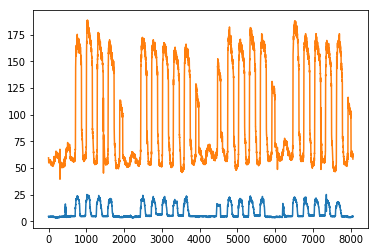

In [35]:
# Let's plot those locals
plt.figure(1)
plt.plot(range(int(points_per_month)), values_49[0:int(points_per_month)])
plt.plot(range(int(points_per_month)), list_of_values[index_md][0:int(points_per_month)])
plt.show()

In [36]:
# Let's print the metadata of each local.
print(all_sites[(all_sites["SITE_ID"] == 761)])
print(all_sites[(all_sites["SITE_ID"]== food_processing_id[d])])

    SITE_ID          INDUSTRY   SUB_INDUSTRY   SQ_FT        LAT        LNG  \
90      761  Light Industrial  Manufacturing  127899  42.107627 -87.789483   

          TIME_ZONE TZ_OFFSET  
90  America/Chicago    -05:00  
    SITE_ID          INDUSTRY     SUB_INDUSTRY   SQ_FT       LAT        LNG  \
99      887  Light Industrial  Food Processing  381939  38.83195 -75.825022   

           TIME_ZONE TZ_OFFSET  
99  America/New_York    -04:00  


In [37]:
# Those locals seems not to be extremely smimilar, so maybe there are not enough Manufacturing samples to train the model,
# or maybe the Manufacotring locals has not a similar behaviour between them.

# Let's compare this local with the rest of Manufacturing locals.
df_fp = all_sites['SUB_INDUSTRY'] == "Manufacturing"
manufacturing_id = all_sites[df_fp]["SITE_ID"].values
list_of_values = []
values_761 = pd.read_csv('./data-enerNoc/all-data/csv/' + str(761) + ".csv")["value"].values
i = 0
for name in manufacturing_id:
    df = pd.read_csv('./data-enerNoc/all-data/csv/' + str(name) + ".csv")
    list_of_values.append(df["value"].values.tolist())
    i = i +1
profile, index = stomp(array(values_761), array(np.stack([np.array(l[0:int(points_per_month)]) for l in list_of_values])), int(points_per_month))

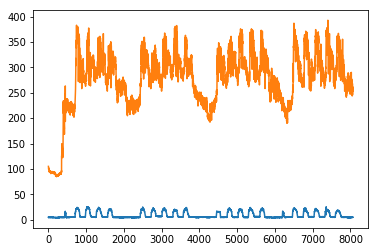

In [38]:
# Let's plot the most similar manufacturing local to this one.
distances = profile.to_numpy()
min_distance = distances[0]
index_md = 0
for d in range(len(distances)):
    if(distances[d] < min_distance) and d !=3:
        min_distance = distances[d]
        index_md = d
plt.figure(1)
plt.plot(range(int(points_per_month)), values_49[0:int(points_per_month)])
plt.plot(range(int(points_per_month)), list_of_values[index_md][0:int(points_per_month)])
plt.show()

In [39]:
print(all_sites[(all_sites["SITE_ID"] == 761)])
print(all_sites[(all_sites["SITE_ID"]== manufacturing_id[d])])

    SITE_ID          INDUSTRY   SUB_INDUSTRY   SQ_FT        LAT        LNG  \
90      761  Light Industrial  Manufacturing  127899  42.107627 -87.789483   

          TIME_ZONE TZ_OFFSET  
90  America/Chicago    -05:00  
    SITE_ID          INDUSTRY   SUB_INDUSTRY   SQ_FT      LAT        LNG  \
98      832  Light Industrial  Manufacturing  186614  35.8111 -89.969061   

          TIME_ZONE TZ_OFFSET  
98  America/Chicago    -05:00  


In [73]:
# The behaviours seems strange, so maybe we coud offer another payment rate for this local for not be treated 
# as a Manufactoring local.